<a href="https://colab.research.google.com/github/ggmeiner22/plot2csv/blob/main/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import io
import math
import base64
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [7]:
CURVE_TYPES = ["linear", "quadratic", "exponential", "logarithmic", "sinusoid", "sigmoid"]
X_AXIS = np.arange(1, 21)


def set_seed(seed: int | None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)


def scale_to_axis(y_raw, low=1.0, high=20.0):
    y_raw = np.asarray(y_raw, dtype=float)
    ymin, ymax = np.min(y_raw), np.max(y_raw)
    if ymax - ymin < 1e-8:
        return np.ones_like(y_raw) * ((low + high) / 2.0)
    y_norm = (y_raw - ymin) / (ymax - ymin)
    return low + y_norm * (high - low)


def to_pixel(x_axis, y_axis, w, h):
    px = int(round((x_axis - 1) / 19.0 * (w - 1)))
    py = int(round((20.0 - y_axis) / 19.0 * (h - 1)))
    return px, py


from PIL import Image, ImageDraw

def _to_hr_px(x_axis, y_axis, W, H):

    px = int(round((x_axis - 1) / 19.0 * (W - 1)))
    py = int(round((20.0 - y_axis) / 19.0 * (H - 1)))
    return px, py

def draw_curve_pretty(y_axis, img_size=50, stroke=2, with_markers=True):
    """
    Render a smooth, antialiased curve with markers at x=1..20.
    Internally draw at high-res and downsample to img_size.
    """
    # High-res canvas for anti-aliasing
    HR = 256                     # internal resolution (bigger => smoother)
    W = H = HR
    line_w = 6                   # high-res line width (gets smoothed on downscale)
    marker_r = 7 if with_markers else 0  # high-res marker radius

    # 1) draw in high-res
    img_hr = Image.new("L", (W, H), color=255)
    dr = ImageDraw.Draw(img_hr)

    # Fine interpolation for a smooth curve
    x_fine = np.linspace(1, 20, 400)
    y_fine = np.interp(x_fine, X_AXIS, y_axis)
    pts = [_to_hr_px(x, y_fine[i], W, H) for i, x in enumerate(x_fine)]

    # Smooth polyline
    for (x0, y0), (x1, y1) in zip(pts[:-1], pts[1:]):
        dr.line((x0, y0, x1, y1), fill=0, width=line_w)

    # Optional: round markers at the 20 sample points
    if with_markers:
        for i, x in enumerate(X_AXIS):
            px, py = _to_hr_px(x, y_axis[i], W, H)
            dr.ellipse((px - marker_r, py - marker_r, px + marker_r, py + marker_r), outline=0, width=3, fill=None)

    # 2) downsample to the requested size with bicubic filter (anti-aliased)
    img = img_hr.resize((img_size, img_size), Image.BICUBIC)
    return img




def sample_params(curve_type):
    if curve_type == "linear":
        a = np.random.uniform(-3, 3)
        b = np.random.uniform(-10, 10)
        return a, b
    if curve_type == "quadratic":
        a = np.random.uniform(-1.5, 1.5)
        b = np.random.uniform(-5, 5)
        c = np.random.uniform(-10, 10)
        return a, b, c
    if curve_type == "exponential":
        A = np.random.uniform(0.5, 3.0)
        k = np.random.uniform(-0.25, 0.25)
        c = np.random.uniform(-3, 3)
        return A, k, c
    if curve_type == "logarithmic":
        A = np.random.uniform(0.5, 5.0)
        shift = np.random.uniform(-2.0, 2.0)
        base = np.random.uniform(1.5, 4.0)
        c = np.random.uniform(-3, 3)
        return A, shift, base, c
    if curve_type == "sinusoid":
        A = np.random.uniform(1.0, 8.0)
        w = np.random.uniform(0.2, 1.0)
        phi = np.random.uniform(0, 2 * math.pi)
        c = np.random.uniform(-5, 5)
        return A, w, phi, c
    if curve_type == "sigmoid":
        A = np.random.uniform(5.0, 20.0)
        k = np.random.uniform(0.2, 1.0)
        x0 = np.random.uniform(5.0, 15.0)
        c = np.random.uniform(-5, 5)
        return A, k, x0, c
    raise ValueError(curve_type)


def gen_curve_values(curve_type, params):
    x = np.asarray(X_AXIS, dtype=float)
    if curve_type == "linear":
        a, b = params
        y = a * x + b
    elif curve_type == "quadratic":
        a, b, c = params
        y = a * x**2 + b * x + c
    elif curve_type == "exponential":
        A, k, c = params
        y = A * np.exp(k * x) + c
    elif curve_type == "logarithmic":
        A, shift, base, c = params
        z = np.maximum(x + shift, 1e-3)
        y = A * (np.log(z) / np.log(base)) + c
    elif curve_type == "sinusoid":
        A, w, phi, c = params
        y = A * np.sin(w * x + phi) + c
    elif curve_type == "sigmoid":
        A, k, x0, c = params
        y = A / (1.0 + np.exp(-k * (x - x0))) + c
    else:
        raise ValueError(curve_type)

    std = np.std(y)
    noise_sigma = 0.02 * std if std > 0 else 0.05
    y_noisy = y + np.random.normal(0, noise_sigma, size=y.shape)
    return scale_to_axis(y_noisy, 1.0, 20.0)


def generate_dataset(
    out_dir="/content/plot2csv_synth",
    n_per_type=200,
    img_size=50,
    jpeg_quality=90,
    seed=42,
    include_base64=True,
):
    set_seed(seed)
    out_dir = os.path.abspath(out_dir)
    img_dir = os.path.join(out_dir, "images")
    os.makedirs(img_dir, exist_ok=True)

    rows = []
    for curve_type in CURVE_TYPES:
        for i in range(n_per_type):
            params = sample_params(curve_type)
            y_axis = gen_curve_values(curve_type, params)
            img = draw_curve_pretty(y_axis, img_size=img_size, stroke=random.choice([1, 1, 2]))

            fname = f"{curve_type}_{i:04d}.jpg"
            path = os.path.join(img_dir, fname)
            img.save(path, format="JPEG", quality=jpeg_quality, subsampling=1)

            if include_base64:
                with io.BytesIO() as buf:
                    img.save(buf, format="JPEG", quality=jpeg_quality, subsampling=1)
                    img_b64 = base64.b64encode(buf.getvalue()).decode("ascii")
            else:
                img_b64 = None

            row = {"type": curve_type, "image": path}
            if include_base64:
                row["image_b64_jpeg"] = img_b64

            for k, yval in enumerate(y_axis, start=1):
                row[f"y{k}"] = float(yval)
                row[f"y{k}_norm"] = float((yval - 1.0) / 19.0)

            rows.append(row)

    df = pd.DataFrame(rows)
    csv_path = os.path.join(out_dir, f"dataset_six_shapes_{len(df)}.csv")
    df.to_csv(csv_path, index=False)
    return csv_path

In [2]:
csv_path = generate_dataset(
    out_dir="/content/plot2csv_synth",  # where images + CSV will go
    n_per_type=200,                    # 6 types × 200 = 1200 samples
    img_size=50,
    jpeg_quality=90,
    seed=42,                           # or None for fresh randomness
    include_base64=True
)
csv_path

'/content/plot2csv_synth/dataset_six_shapes_1200.csv'

In [8]:

df = pd.read_csv(csv_path)
df.head()        # show first few rows
len(df)          # confirm total rows

1200

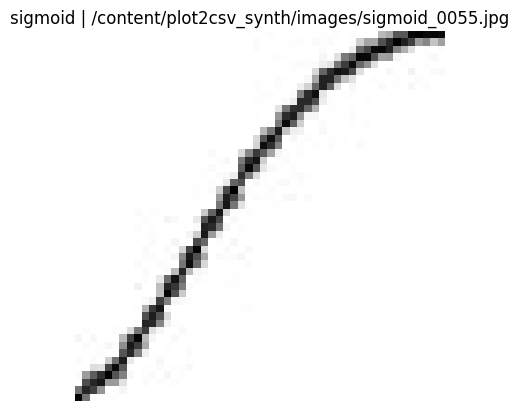

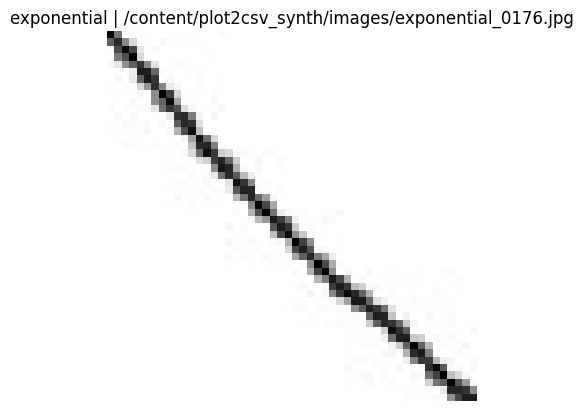

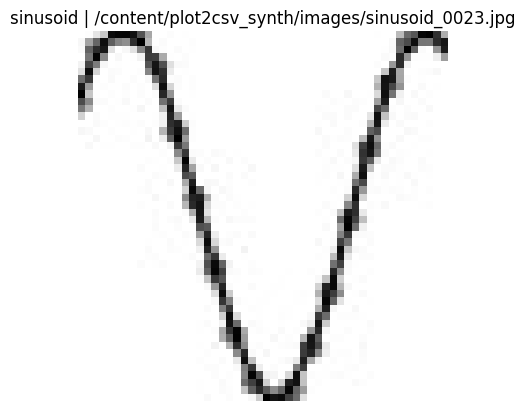

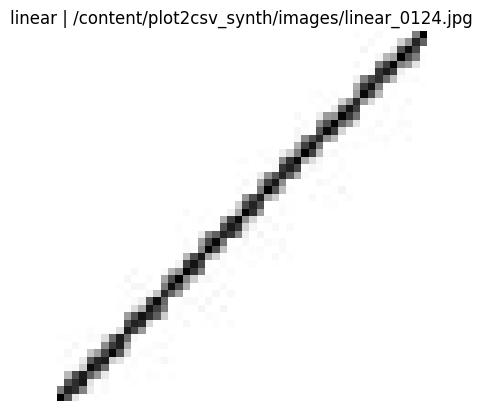

In [13]:
# Pick a few sample rows
sample_rows = df.sample(4)  # random 4 samples

for idx, row in sample_rows.iterrows():
    img = Image.open(row["image"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{row['type']} | {row['image']}")
    plt.axis('off')
    plt.show()

In [10]:
def load_images_to_numpy(image_paths, img_size=(50, 50)):
    imgs = []
    for p in image_paths:
        img = Image.open(p).convert("L")
        img = img.resize(img_size)
        img_arr = np.array(img, dtype=np.float32) / 255.0  # normalize to [0,1]
        imgs.append(img_arr)
    return np.stack(imgs)

csv_path = '/content/plot2csv_synth/dataset_six_shapes_1200.csv'


df = pd.read_csv(csv_path)

X = load_images_to_numpy(df["image"].tolist(), img_size=(50, 50))



print("X shape:", X.shape)

# Map curve types to integer labels
label_map = {curve_type: idx for idx, curve_type in enumerate(df["type"].unique())}
y = df["type"].map(label_map).values

print("Label mapping:", label_map)
print("y shape:", y.shape)
print("First 10 labels:", y[:10])

num_classes = len(label_map)
y_onehot = np.eye(num_classes)[y]

print("y_onehot shape:", y_onehot.shape)

X shape: (1200, 50, 50)
Label mapping: {'linear': 0, 'quadratic': 1, 'exponential': 2, 'logarithmic': 3, 'sinusoid': 4, 'sigmoid': 5}
y shape: (1200,)
First 10 labels: [0 0 0 0 0 0 0 0 0 0]
y_onehot shape: (1200, 6)
